In [759]:
from pyhive import hive
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pandasql as ps
from pandasql import sqldf
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=3)
sns.set(color_codes=True)
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn import model_selection
import shap







pysqldf = lambda q: sqldf(q, globals())


In [760]:
HIVE_SERVER=os.environ['HIVE_SERVER']
HIVE_USER_NAME = os.environ['HIVE_USER_NAME']
HIVE_TOKEN = os.environ['HIVE_TOKEN']
conn = hive.connect(host = HIVE_SERVER,auth = 'LDAP',username = HIVE_USER_NAME,password=HIVE_TOKEN,database = 'med')
cursor = conn.cursor()

def query_to_pandas(query):
    print ('going to execute ' + query)
    cursor.execute(query)
    value = cursor.fetchall()
    columnNames = [desc[0] for desc in cursor.description]
    columnNames = [re.sub('.*\.', '', x) for x in columnNames]
    df = pd.DataFrame(data = value, columns = columnNames)
    return df

In [761]:
def get_coverage(df):
    coverage_df = pd.DataFrame(columns=["col_name","coverage_percentage"])
    for c in list(df.columns):
        try:
            na_values = len(df[df[c] <= 0.01])
            covered_values_perc = ((len(df) - na_values)/len(df)) * 100
            coverage_df = coverage_df.append({'col_name':c,'coverage_percentage':covered_values_perc},ignore_index=True)
        except TypeError:
            continue
        except:
            continue
    return coverage_df

In [762]:
def replace_space_in_col_names(df):
    new_cols = [x.replace(" ","_") for x in df.columns]
    df.columns = new_cols

In [763]:
def replace_national_text_with_value(s):
    if s == 'Same_as_the_national_average':
        return 3
    if s == 'Above_the_national_average':
        return 5
    if s == 'Below_the_national_average':
        return 1
    return 3
    

In [764]:
def replace_mortality_payment_text_with_value(s):
    if s == 'Better_mortality_and_lower_payment':
        return 10
    if s == 'Better_mortality_and_average_payment':
        return 8
    if s == 'Average_mortality_and_lower_payment':
        return 6
    if s == 'Average_mortality_and_higher_payment':
        return 4
    if s == 'Worse_mortality_and_average_payment':
        return 3
    if s == 'Worse_mortality_and_higher_payment':
        return 1

    return 5


In [765]:
#customers-months distributio
q = """SELECT account_id , count(distinct concat(year(trans_date) , month(trans_date))) yearmonth 
from 
transactions
group by account_id
"""
cust_months_count = query_to_pandas(q)


going to execute SELECT account_id , count(distinct concat(year(trans_date) , month(trans_date))) yearmonth 
from 
transactions
group by account_id



/home/yehia.elshater/ve3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


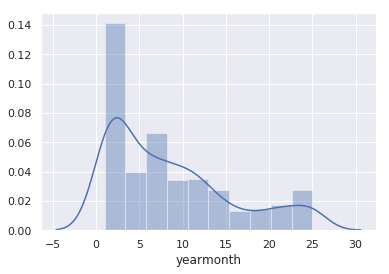

In [766]:
sns.distplot(cust_months_count["yearmonth"], kde=True,bins=10)


In [767]:
non_ahd_features_df = pd.read_csv("../Hospitals_Features/non_ahd_data.csv")
#non-ahd processing
#replace spaces with _
non_ahd_features_df = non_ahd_features_df.replace(' ', '_', regex=True)
non_ahd_features_df = non_ahd_features_df.replace(',', '', regex=True)
non_ahd_features_df = non_ahd_features_df.replace('Not_Available_(5)', '-1', regex=False)
non_ahd_features_df = non_ahd_features_df.replace('Not_Available', '-1', regex=False)

non_ahd_features_df["Mortality_national_comparison"] = non_ahd_features_df["Mortality_national_comparison"].apply(replace_national_text_with_value)
non_ahd_features_df["Safety_of_care_national_comparison"] = non_ahd_features_df["Safety_of_care_national_comparison"].apply(replace_national_text_with_value)
non_ahd_features_df["Readmission_national_comparison"] = non_ahd_features_df["Readmission_national_comparison"].apply(replace_national_text_with_value)
non_ahd_features_df["Effectiveness_of_care_national_comparison"] = non_ahd_features_df["Effectiveness_of_care_national_comparison"].apply(replace_national_text_with_value)
non_ahd_features_df["Patient_experience_national_comparison"] = non_ahd_features_df["Patient_experience_national_comparison"].apply(replace_national_text_with_value)
non_ahd_features_df["value_of_care_heart_failure_patients"] = non_ahd_features_df["value_of_care_heart_failure_patients"].apply(replace_national_text_with_value)
non_ahd_features_df["value_of_care_heart_attack_patients"] = non_ahd_features_df["value_of_care_heart_attack_patients"].apply(replace_mortality_payment_text_with_value)
non_ahd_features_df["Emergency_Services"] = non_ahd_features_df["Emergency_Services"].apply(lambda x : 1 if x=='Yes' else 0)
non_ahd_features_df["Meets_criteria_for_meaningful_use_of_EHRs"] = non_ahd_features_df["Meets_criteria_for_meaningful_use_of_EHRs"].apply(lambda x : 1 if x=='Y' else 0)


#cat to bin
non_ahd_features_df = pd.get_dummies(non_ahd_features_df,columns=["Hospital_Ownership"])
non_ahd_features_df["Provider_ID"] = non_ahd_features_df["Provider_ID"].apply(lambda x : str(x).zfill(6))

In [768]:
hospitals_gi_df = pd.read_csv("../../web_data/Hospital_General_Information.csv")
hospitals_gi_df = hospitals_gi_df[["Provider ID","Hospital Name"]]
hospitals_gi_df.columns = ["Provider_ID","Hospital_Name"]
hospitals_gi_df["Provider_ID"] = hospitals_gi_df["Provider_ID"].astype(str)
hospitals_gi_df["Provider_ID"] = hospitals_gi_df["Provider_ID"].apply(lambda x : str(x).zfill(6))

#merge definitive hospital names
definitive_ahd_df = pd.read_csv("../DefinitiveAhdDifference.csv")[["Provider_Number","Hospital_Name"]]
definitive_ahd_df["Provider_Number"] = definitive_ahd_df["Provider_Number"].astype(str)
definitive_ahd_df["Provider_Number"]= definitive_ahd_df["Provider_Number"].apply(lambda x : x.zfill(6))
definitive_ahd_df = definitive_ahd_df.rename(columns={"Provider_Number":"Provider_ID"})
hospitals_gi_df = hospitals_gi_df.append(definitive_ahd_df,sort=False).drop_duplicates()
hospitals_gi_df = hospitals_gi_df.groupby("Provider_ID").tail(1) #keep the most recent entry (favour definitive data)


ahd_features_df = pd.read_csv("../Hospitals_Features/ahd_features.csv")
sf_account_pid_mapping_df = pd.read_csv("../sf_account_provider_id_fuzzy_match_with_address_v1.csv")
sf_account_pid_mapping_df = sf_account_pid_mapping_df[sf_account_pid_mapping_df.match == 1]
sf_account_pid_mapping_df = sf_account_pid_mapping_df.drop(["ShippingPostalCode","Name","ShippingCity","ShippingStreet"],axis=1,errors='ignore')



ahd_features_df["Provider_ID"] = ahd_features_df["Provider_ID"].apply(lambda x : str(x).zfill(6))
sf_account_pid_mapping_df["Provider_ID"] = sf_account_pid_mapping_df["Provider_ID"].apply(lambda x : str(x).zfill(6))


sf_accounts_df = pd.read_excel("../../data/QuVa-GAIL DataRequest_6_7_8_Addition2.xlsx",0)
replace_space_in_col_names(sf_accounts_df)
sf_account_pid_mapping_df = pd.merge(sf_account_pid_mapping_df,sf_accounts_df,on=["Account_id"])

#trans_df = query_to_pandas("select * from transactions")


In [769]:
sf_account_pid_mapping_df.columns

Index(['Account_id', 'Provider_ID', 'Hospital_Name', 'ZIP_Code', 'City',
       'match', 'fuzzy_name_score', 'Address', 'Name', 'Type', 'ParentId',
       'BillingStreet', 'BillingCity', 'BillingState', 'BillingPostalCode',
       'BillingCountry', 'BillingStateCode', 'BillingCountryCode',
       'ShippingStreet', 'ShippingCity', 'ShippingState', 'ShippingPostalCode',
       'ShippingCountry', 'ShippingStateCode', 'ShippingCountryCode',
       'Description', 'OwnerId', 'CreatedDate', 'LastModifiedDate',
       'LastActivityDate', 'AccountSource', 'Customer_Prospect_Type__c',
       'Bed_Number__c', 'Ship_To_Name__c', 'GPO_Text__c',
       'Pharmacy_Network_text__c', 'Hospital_System_text__c',
       'Infor_Customer_Type__c', 'DUET__creditholdreason__c',
       'DUET__creditlimit__c', 'DUET__customertypeid__c',
       'DUET__extrecordid__c', 'DUET__paymenttermid__c'],
      dtype='object')

In [770]:
#merge the existing mappings with the new manually matched mappings
sf_account_pid_mapping_manual_recent_df = pd.read_excel("../../data/matching/sf_all_accounts_with_manual_matching_v3.xlsx")
sf_account_pid_mapping_manual_recent_df = sf_account_pid_mapping_manual_recent_df[sf_account_pid_mapping_df.columns]
sf_account_pid_mapping_manual_recent_df["Provider_ID"] = sf_account_pid_mapping_manual_recent_df["Provider_ID"].apply(lambda x : str(x).zfill(6))
print(len(sf_account_pid_mapping_manual_recent_df))
print(len(sf_account_pid_mapping_df))
#len(sf_account_pid_mapping_manual_recent_df[sf_account_pid_mapping_manual_recent_df.Account_id.isin(sf_account_pid_mapping_df.Account_id)])
sf_account_pid_mapping_df = pd.concat([sf_account_pid_mapping_df,sf_account_pid_mapping_manual_recent_df])
sf_account_pid_mapping_df.to_csv("sf_account_pid_mapping_df.csv",index=False)

177
718


In [771]:
len(sf_account_pid_mapping_df)

895

In [772]:
trans_df = pd.read_excel("../../data/QuVa-GAIL DataRequest_4_5.xlsx",1)
replace_space_in_col_names(trans_df)
trans_df["Customer_ID"] = trans_df["Customer_ID"].astype(str)
trans_df = pd.merge(trans_df,sf_accounts_df[["Account_id","DUET__extrecordid__c"]],left_on="Customer_ID", right_on="DUET__extrecordid__c",how='left')

In [773]:
print(sf_account_pid_mapping_df.groupby('Type').count()["Account_id"])
print(len(sf_account_pid_mapping_df[sf_account_pid_mapping_df.Account_id.isin(trans_df.Account_id.unique())]))
print(len(sf_account_pid_mapping_df[~sf_account_pid_mapping_df.Account_id.isin(trans_df.Account_id.unique())]))

Type
Customer    873
Prospect     22
Name: Account_id, dtype: int64
557
338


In [809]:
#definitive data processing
definitive_ahd_features_df = pd.read_csv("../Hospitals_Features/definitive_ahd_features.csv")
definitive_ahd_features_df["Provider_ID"] = definitive_ahd_features_df["Provider_ID"].astype(str)
definitive_ahd_features_df["Provider_ID"] = definitive_ahd_features_df["Provider_ID"].apply(lambda x : x.zfill(6))


#To include non-ahd features
definitive_third_party_df = pd.merge(non_ahd_features_df,definitive_ahd_features_df,on="Provider_ID",how='right')
for c in non_ahd_features_df.columns:
    if c in ["Hospital_Name","ZIP_Code","Provider_ID"]:
        continue
    non_ahd_features_df[c] = non_ahd_features_df[c].astype(float)
    definitive_third_party_df[c] = definitive_third_party_df[c].fillna(non_ahd_features_df[c].median())
#definitive_third_party_df = definitive_third_party_df.drop(["ZIP_Code","zipcode","Latitude","Longitude"],axis=1)



In [810]:
# to include non-ahd features
third_party_df = pd.merge(non_ahd_features_df,ahd_features_df,on="Provider_ID",how='right')
print(len(third_party_df))
#merge existing third party hospitals with definitive hostpitals
third_party_df = third_party_df.append(definitive_third_party_df[third_party_df.columns])
print(len(third_party_df))

third_party_df = third_party_df.fillna(-1)
third_party_df["ZIP_Code"] = third_party_df["ZIP_Code"].astype(int)
third_party_df["ZIP_Code"] = third_party_df["ZIP_Code"].astype(str)
third_party_df = third_party_df.drop(['zipcode'],axis=1,errors='ignore')
third_party_df = third_party_df.drop(["Hospital_Name"],axis=1)
third_party_df.to_csv("third_party_df.csv",index=False)
#Reconstruct hospital name from the lookup file

third_party_df = pd.merge(third_party_df.groupby('Provider_ID').tail(1),hospitals_gi_df.drop_duplicates(),on="Provider_ID")



print(len(third_party_df))
sf_account_third_party_df = pd.merge(sf_account_pid_mapping_df,third_party_df,on="Provider_ID",how='right')
print(len(sf_account_third_party_df))
sf_account_third_party_df
#get_coverage(third_party_df).to_clipboard(index=False)
#get_coverage(sf_account_third_party_df).to_clipboard(index=False)
list(sf_account_third_party_df.columns)
sf_account_third_party_df = sf_account_third_party_df.drop(["Hospital_Name_y","ZIP_Code_x"],axis=1)
sf_account_third_party_df = sf_account_third_party_df.rename(columns={'Hospital_Name_x':'Hospital_Name' , 'ZIP_Code_y' : 'ZIP_Code'})
sf_account_third_party_df["ZIP_Code"] = sf_account_third_party_df["ZIP_Code"].astype(str)
#sf_account_third_party_df["ZIP_Code"]


4684
5920
5918
6036


In [811]:
print(len(pd.merge(sf_account_pid_mapping_df,third_party_df,on="Provider_ID")))
d = pd.merge(sf_account_pid_mapping_df,third_party_df,on="Provider_ID")
print(len(d[d.Account_id.isin(trans_df.Account_id.unique())]))
print(len(d[~d.Account_id.isin(trans_df.Account_id.unique())]))

854
543
311


In [812]:
#third_party_df.to_csv("../Hospitals_Features/hospitals_third_party_data.csv",index=False)
#sf_account_third_party_df.to_csv("../Hospitals_Features/sf_accounts_with_third_party.csv",index=False)



In [813]:
sf_account_third_party_df_all = pd.merge(sf_account_third_party_df,
                                         sf_accounts_df,
                                         left_on="Account_id",
                                        right_on= "Account_id",how='left')
cols_to_drop = []
for c in sf_account_third_party_df_all.columns:
    if '_' in c and c.split('_')[-1] == "y":
        cols_to_drop.append(c)
        sf_account_third_party_df_all.rename(columns={'_'.join(c.split('_')[:-1]) + '_x' : '_'.join(c.split('_')[:-1])},inplace=True)

sf_account_third_party_df_all = sf_account_third_party_df_all.drop(cols_to_drop,axis=1)


In [814]:
#Assign Customer/Prospect based on transactions 
trans_cust_account_ids = trans_df["Account_id"].unique()
sf_account_third_party_df_all["Is_Customer"] = sf_account_third_party_df_all["Account_id"].apply(lambda x : 1 if x in trans_cust_account_ids else 0)
sf_account_third_party_df_all.groupby('Is_Customer').count()["Account_id"]

#drop non-needed columns 
drop_cols = ['Provider_ID','Hospital_Name','City','match','fuzzy_name_score','Address','Name','Type','ParentId','BillingStreet','BillingCity','BillingState',
'BillingPostalCode','BillingCountry','BillingStateCode','BillingCountryCode','ShippingStreet','ShippingCity','ShippingState','ShippingPostalCode','ShippingCountry','ShippingStateCode','ShippingCountryCode',
'Description','OwnerId','CreatedDate','LastModifiedDate','LastActivityDate','AccountSource','Bed_Number__c','Ship_To_Name__c','DUET__creditholdreason__c','DUET__creditlimit__c','DUET__customertypeid__c','DUET__extrecordid__c','DUET__paymenttermid__c','ZIP_Code','Customer_Prospect_Type__c','Infor_Customer_Type__c','Latitude'
,'Longitude']
sf_account_third_party_df_all_2 = sf_account_third_party_df_all.drop(drop_cols,axis=1)

#exclude third-party/non-QuVa Customers
sf_account_third_party_df_all_2 = sf_account_third_party_df_all_2[sf_account_third_party_df_all_2.Account_id.notnull()]

#replace spaces with _
sf_account_third_party_df_all_2 = sf_account_third_party_df_all_2.replace(' ', '_', regex=True)
sf_account_third_party_df_all_2 = sf_account_third_party_df_all_2.replace(',', '', regex=True)
sf_account_third_party_df_all_2 = sf_account_third_party_df_all_2.replace('Not_Available_(5)', '-1', regex=False)
sf_account_third_party_df_all_2 = sf_account_third_party_df_all_2.replace('Not_Available', '-1', regex=False)


#cat to bin string values
#cat_to_bin_cols = ["GPO_Text__c","Hospital_System_text__c","Pharmacy_Network_text__c","value_of_care_heart_failure_patients"
#                   ,"Type_Of_Facility","Is_Low_Volume_Hospital","Urban_Rural","Hospital_Ownership"]
cat_to_bin_cols = ["GPO_Text__c","Hospital_System_text__c","Pharmacy_Network_text__c"
                   ,"Type_Of_Facility","Is_Low_Volume_Hospital","Urban_Rural"]


sf_account_third_party_df_all_2 = pd.get_dummies(sf_account_third_party_df_all_2,columns=cat_to_bin_cols)

sf_account_third_party_df_all_2["Mortality_national_comparison"] = sf_account_third_party_df_all_2["Mortality_national_comparison"].apply(replace_national_text_with_value)
sf_account_third_party_df_all_2["Safety_of_care_national_comparison"] = sf_account_third_party_df_all_2["Safety_of_care_national_comparison"].apply(replace_national_text_with_value)
sf_account_third_party_df_all_2["Readmission_national_comparison"] = sf_account_third_party_df_all_2["Readmission_national_comparison"].apply(replace_national_text_with_value)
sf_account_third_party_df_all_2["Effectiveness_of_care_national_comparison"] = sf_account_third_party_df_all_2["Effectiveness_of_care_national_comparison"].apply(replace_national_text_with_value)
sf_account_third_party_df_all_2["Patient_experience_national_comparison"] = sf_account_third_party_df_all_2["Patient_experience_national_comparison"].apply(replace_national_text_with_value)
sf_account_third_party_df_all_2["value_of_care_heart_failure_patients"] = sf_account_third_party_df_all_2["value_of_care_heart_failure_patients"].apply(replace_national_text_with_value)
sf_account_third_party_df_all_2["value_of_care_heart_attack_patients"] = sf_account_third_party_df_all_2["value_of_care_heart_attack_patients"].apply(replace_mortality_payment_text_with_value)
sf_account_third_party_df_all_2["Emergency_Services"] = sf_account_third_party_df_all_2["Emergency_Services"].apply(lambda x : 1 if x=='Yes' else 0)
sf_account_third_party_df_all_2["Meets_criteria_for_meaningful_use_of_EHRs"] = sf_account_third_party_df_all_2["Meets_criteria_for_meaningful_use_of_EHRs"].apply(lambda x : 1 if x=='Y' else 0)
sf_account_third_party_df_all_2.to_csv('tmp.csv')

In [815]:
#coverage in general

print(len(sf_account_pid_mapping_df[~sf_account_pid_mapping_df.Provider_ID.isin(ahd_features_df.Provider_ID.unique())]))
print(len(sf_account_pid_mapping_df[sf_account_pid_mapping_df.Provider_ID.isin(ahd_features_df.Provider_ID.unique())]))
print(len(sf_account_pid_mapping_df[~sf_account_pid_mapping_df.Provider_ID.isin(non_ahd_features_df.Provider_ID.unique())]))
print(len(sf_account_pid_mapping_df[sf_account_pid_mapping_df.Provider_ID.isin(non_ahd_features_df.Provider_ID.unique())]))


46
849
93
802


In [816]:
#Columns sources

columns_sources_df = pd.DataFrame()
for c in list(non_ahd_features_df.columns):
    if c not in cols_to_drop and c not in drop_cols:
        columns_sources_df = columns_sources_df.append({'Column':c, 'Source':'Third_Party_Free_Data'},ignore_index=True)

for c in list(ahd_features_df.columns):
    if c not in cols_to_drop and c not in drop_cols and c not in list(columns_sources_df["Column"]):
        columns_sources_df = columns_sources_df.append({'Column':c, 'Source':'Third_Party_AHD'},ignore_index=True)
        
for c in list(sf_account_third_party_df_all_2.columns):
    if c not in cols_to_drop and c not in drop_cols and c not in list(columns_sources_df["Column"]):
        columns_sources_df = columns_sources_df.append({'Column':c, 'Source':'QuVa_SF'},ignore_index=True)



columns_sources_df = columns_sources_df[columns_sources_df.Column != 'zipcode']
#columns_sources_df

In [783]:
np.mean(np.nonzero([-1,1,2]))

1.0

In [817]:
def rollup_features(df,columns_sources_filtered_df):
    df = df[columns_sources_filtered_df.Column]
    df["Avg_Liabilities"] = (df["Total_Liabilities_2017"] + df["Total_Liabilities_2016"])/2
    df["Avg_Net_Patient_Rev"] = (df["Net_Patient_Rev_2017"] + df["Net_Patient_Rev_2016"])/2
    df["Avg_Net_Income_or_Loss"] = (df["Net_Income_or_Loss_2017"] + df["Net_Income_or_Loss_2016"])/2
    df = df.drop(["Total_Liabilities_2017","Total_Liabilities_2016","Net_Patient_Rev_2016","Net_Patient_Rev_2017","Net_Income_or_Loss_2017","Net_Income_or_Loss_2016"],axis=1)

    ip_avg_stay_cols = ['ip_avg_stay_in_days_Cardiology',
    'ip_avg_stay_in_days_Cardiovascular_Surgery',
    'ip_avg_stay_in_days_Inpatient_Medical_Service_Total',
    'ip_avg_stay_in_days_Medicine',
    'ip_avg_stay_in_days_Surgery']


    df['ip_avg_stay'] = df.apply(lambda row:np.mean(row[ip_avg_stay_cols]),axis=1)
    df = df.drop(ip_avg_stay_cols,axis=1)


    ip_avg_cost_cols = ['ip_adjusted_avg_cost_Cardiology','ip_adjusted_avg_cost_Cardiovascular_Surgery','ip_adjusted_avg_cost_Inpatient_Medical_Service_Total','ip_adjusted_avg_cost_Medicine','ip_adjusted_avg_cost_Surgery','ip_adjusted_avg_cost_Vascular_Surgery']
    df['ip_avg_cost'] = df.apply(lambda row:np.mean(row[ip_avg_cost_cols]),axis=1)
    df = df.drop(ip_avg_cost_cols,axis=1)



    no_ip_cols = ['no_of_inpatients_Cardiology','no_of_inpatients_Cardiovascular_Surgery','no_of_inpatients_Inpatient_Medical_Service_Total','no_of_inpatients_Medicine','no_of_inpatients_Surgery','no_of_inpatients_Vascular_Surgery']
    df["no_of_inpatients_Total"] = df.apply(lambda row : np.mean(row[no_ip_cols]),axis=1)
    df = df.drop(no_ip_cols,axis=1)

    no_op_claims_cols = ['Number_Of_OP_Claims_Anesthesia',
    'Number_Of_OP_Claims_Blood_Storage_and_Processing',
    'Number_Of_OP_Claims_Cardiac_Cath_Lab',
    'Number_Of_OP_Claims_Cardiology',
    'Number_Of_OP_Claims_Drugs_Requiring_Specific_Identification',
    'Number_Of_OP_Claims_Emergency_Room',
    'Number_Of_OP_Claims_IV_Therapy',
    'Number_Of_OP_Claims_Medical_Surgical_Supplies']

    df["Num_Of_OP_Claims_Total"] = df.apply(lambda row : np.mean(row[no_op_claims_cols]),axis=1)
    df = df.drop(no_op_claims_cols,axis=1)
    return df

    

In [818]:
#filter the features ... include the rolling-up ones 
#one time run -- columns_sources_df.to_csv("columns_sources_df_with_filter.csv",index=False)

pd.options.mode.chained_assignment = None

columns_sources_filtered_df = pd.read_csv("columns_sources_df_with_filter.csv")
columns_sources_filtered_df = columns_sources_filtered_df[columns_sources_filtered_df.Filter == 1]
sf_account_third_party_df_all_2_filtered = rollup_features(sf_account_third_party_df_all_2,columns_sources_filtered_df)


In [819]:
X = sf_account_third_party_df_all_2_filtered.drop(["Account_id","Is_Customer"],axis=1)
y = sf_account_third_party_df_all_2_filtered["Is_Customer"]

#convert to float --- remove OP for now
for c in X.columns:
    '''
    if "OP" in c or "op" in c:
        X = X.drop(c,axis=1)
        continue
    '''
    X[c] = X[c].astype(float)
    




min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X.values)
x_scaled_df = pd.DataFrame(x_scaled,columns=X.columns)
print(len(x_scaled_df.columns))


#Remove features with 75% quantile less than 0.11
third_qntl_df = pd.DataFrame()
for c in x_scaled_df:
    try:
       third_qntl_df = third_qntl_df.append({'col':c , 'third_qntl': x_scaled_df[c].describe()["75%"]},ignore_index=True)
    except KeyError:
        continue


third_qntl_df = third_qntl_df[third_qntl_df.third_qntl < 0.11]
x_scaled_df = x_scaled_df.drop(list(third_qntl_df["col"]),axis=1)
print(len(x_scaled_df.columns))
x_scaled_df_to_save = x_scaled_df.copy()
x_scaled_df_to_save["Account_id"] = sf_account_third_party_df_all_2_filtered["Account_id"]
#x_scaled_df_to_save.to_csv("x_scaled_df_to_save.csv",index=False)

51
32


In [853]:
#correlation between the features and revenue

trans_df["year_month"] = trans_df["Order_Date"].apply(lambda x : str(x.year) + str(x.month).zfill(2)) 
trans_more_than_6months_df = trans_df.groupby('Account_id').filter(lambda x : x["year_month"].nunique() >= 4)
trans_avg_revenue_df = trans_df.groupby('Account_id').sum()["Daily_Revenue"].reset_index()

In [867]:
trans_avg_revenue_df_tp_joined = pd.merge(trans_more_than_6months_df,x_scaled_df_to_save)

#trans_avg_revenue_df_tp_joined.drop(["Account_id","Item_ID","Fiscal_Year","Shelf_Life_Days"],axis=1).corr()[["Daily_Revenue","Total_Costs","ip_total_costs","ip_gross_salaries","total_ip_days","Total_Inpatient_Days","no_of_inpatients_Total","beds"]].reset_index().to_csv('sum_revenue_features_corr_3.csv',index=False)
#trans_avg_revenue_df_tp_joined.drop(["Account_id"],axis=1).corr()


trans_avg_revenue_df_tp_joined[["Daily_Revenue","Total_Costs","ip_total_costs","ip_gross_salaries","total_ip_days","Total_Inpatient_Days","no_of_inpatients_Total","beds"]].corr().reset_index().to_csv('sum_revenue_features_corr_3.csv',index=False)
#trans_avg_revenue_df_tp_joined
#print(len(trans_df.Account_id.unique()))

In [822]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=600)
tsne_results = tsne.fit_transform(x_scaled_df)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 854 samples in 0.001s...
[t-SNE] Computed neighbors for 854 samples in 0.048s...
[t-SNE] Computed conditional probabilities for sample 854 / 854
[t-SNE] Mean sigma: 0.283818
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.223335
[t-SNE] Error after 600 iterations: 0.406346


In [823]:
tsne_df = pd.DataFrame(tsne_results)
tsne_df.columns = ["tsne1","tsne2"]
tsne_df["Is_Customer"] = y
#x_scaled_df["tsne1"] = tsne_df["tsne1"]
#x_scaled_df["tsne2"] = tsne_df["tsne2"]

In [ ]:
sns.set(style="ticks")
g = sns.catplot(x="tsne1", y="tsne2", hue="Is_Customer", data=tsne_df)

In [824]:
import lightgbm as lgb
def run_lgb(train_X, train_y,num_iterations=1000):
    params = {
        #"objective" : "quantile",
        "objective" : "binary",
        #"metric" : "binary_logloss",
        'unbalance': True,
        "num_leaves" : 30,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.9,
        "feature_fraction" : 0.8,
        #"bagging_frequency" : 5,
        "bagging_seed" : 13
        #'metric': 'rmsle'
    }
    lgtrain = lgb.Dataset(train_X, label=train_y)
    model = lgb.train(params, lgtrain, num_iterations, verbose_eval=50)
    return model

In [825]:
from sklearn.metrics import roc_auc_score,average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score,average_precision_score,f1_score

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=113)
roc_auc_scores = []
avg_precision_scores=[]
for train_index, test_index in kf.split(x_scaled_df):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    model = run_lgb(X_train,y_train)
    y_predict = model.predict(X_test)
    #print(classification_report(y_test, y_predict.round(),target_names=["Prospect","Customer"]))
    roc_auc_scores.append(roc_auc_score(y_test,y_predict))
    avg_precision_scores.append(average_precision_score(y_test,y_predict))


print(np.average(roc_auc_scores))
print(np.average(avg_precision_scores))

X_train, X_test, y_train, y_test = train_test_split(x_scaled_df, y, test_size=0.15, random_state=117)
model = run_lgb(X_train,y_train)
y_predict = model.predict(X_test)

print(classification_report(y_test, y_predict.round(),target_names=["Prospect","Customer"]))
print(roc_auc_score(y_test,y_predict))
print(average_precision_score(y_test,y_predict))
#f1_score(y_test,y_predict,average='macro')

#lgb.plot_importance(model, max_num_features=50)
fi=pd.DataFrame(model.feature_importance()).T
fi.columns = x_scaled_df.columns
fi = fi.T.reset_index()
fi.columns = ["Feature","Importance_Score"]
fi.sort_values(by="Importance_Score").to_csv("light_gbm_fi.csv",index=False)



0.6650078787621065
0.7634114562338417
             precision    recall  f1-score   support

   Prospect       0.54      0.55      0.55        47
   Customer       0.74      0.73      0.74        82

avg / total       0.67      0.67      0.67       129

0.7149714582252206
0.7862172887395537


In [826]:
#export columns sources: WARNING - NEED MANUAL ASSIGNMENT 
#pd.merge(pd.DataFrame(x_scaled_df.columns,columns=["Column"]),columns_sources_df,on="Column").to_csv("columns_sources.csv",index=False)
column_sources_modified = pd.read_csv('columns_sources.csv')
column_sources_modified.columns = ["feature","source"]
column_sources_modified = pd.merge(column_sources_modified,pd.DataFrame(x_scaled_df.columns,columns=["feature"]),how='right').fillna('Third_Party_AHD')


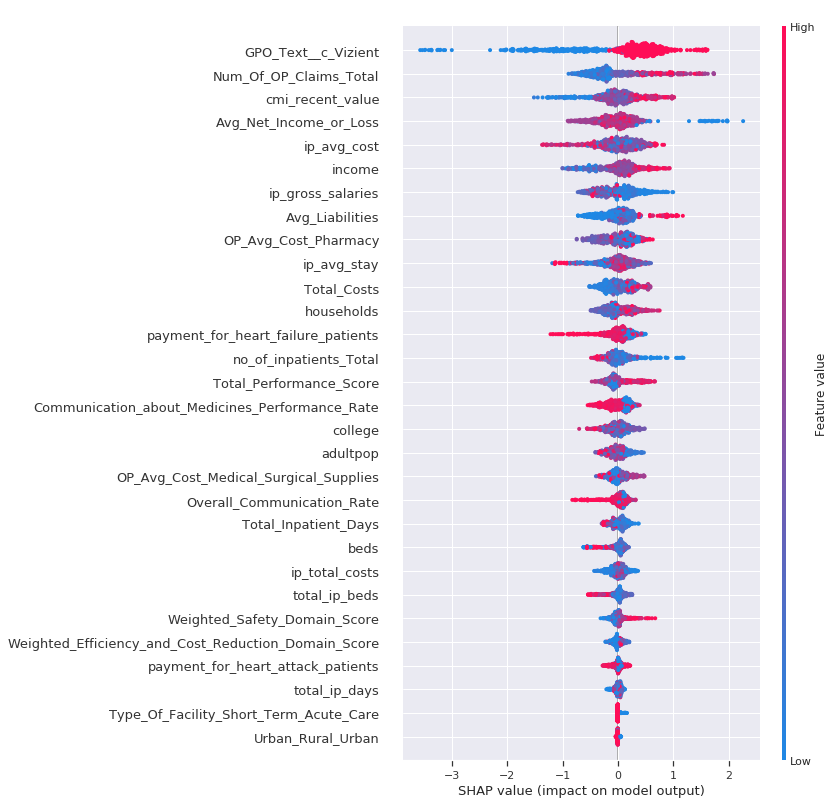

In [827]:

shap.initjs()
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_scaled_df)
# visualize the first prediction's explanation
#shap.force_plot(explainer.expected_value, shap_values[0,:], x_scaled_df.iloc[0,:])
#shap.summary_plot(shap_values, x_scaled_df,max_display=len(x_scaled_df.columns),show=False,title="QuVa Prediction Features")
shap.summary_plot(shap_values, x_scaled_df,max_display=30,show=False,title="QuVa Prediction Features")

#shap.summary_plot(shap_values, x_scaled_df, plot_type="bar")

# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
#shap.dependence_plot("ip_total_sq_feet", shap_values, x_scaled_df,display_features=None)

#ax = lgb.plot_tree(model, tree_index=83, figsize=(20, 8), show_info=['split_gain'])
#plt.show()

#plt.savefig('shap_all_features.png',bbox_inches='tight', pad_inches=0)


In [ ]:
shap_values.shape

In [828]:
def get_SHAP_features_importance(shap_values,all_features_names):
    global_shap_values = np.abs(shap_values).mean(0)
    shap_df = pd.DataFrame([global_shap_values],columns=all_features_names).T.reset_index()
    #shap_df.columns = list(x_scaled_df.columns)
    shap_df.columns = ["feature","mean_shap_value"]
    shap_df = shap_df.sort_values(by="mean_shap_value",ascending=False)
    return shap_df 
    
#shap_df = get_SHAP_features_importance(shap_values,list(x_scaled_df.columns))
#shap_df

In [829]:
def get_SHAP_model_effect(shap_values,x_scaled_df,customer_key_column_name=''):
    shap_df = get_SHAP_features_importance(shap_values,list(x_scaled_df.columns))
    shap_features_effect_df = pd.DataFrame()

    all_shape_values = pd.DataFrame(shap_values,columns=x_scaled_df.columns)
    #all_shape_values["Account_id"] = sf_account_third_party_df_all_2["Account_id"]
    if customer_key_column_name!='':
        all_shape_values[customer_key_column_name] = sf_account_third_party_df_all_2[customer_key_column_name]
    

    x_scaled_df_2 = x_scaled_df.copy()
    scaled_cols = ['scaled_' + c for c in x_scaled_df_2.columns]

    x_scaled_df_2.columns = scaled_cols
    all_shape_values_joined = pd.concat([all_shape_values, x_scaled_df_2], axis=1, sort=False)


    for c in all_shape_values.columns:
        if c == customer_key_column_name:
            continue
        try:
            scaled_col_name = "scaled_" + c
            #print(scaled_col_name)
            current_col_mean = all_shape_values_joined[scaled_col_name].mean()
            all_shape_values_joined_cust = all_shape_values_joined[all_shape_values_joined[c] > 0] 
            all_shape_values_joined_non_cust = all_shape_values_joined[all_shape_values_joined[c] <= 0] 

            all_shape_values_joined_cust_high_value_count = len(np.where (all_shape_values_joined_cust[scaled_col_name] >= current_col_mean)[0])
            all_shape_values_joined_cust_low_value_count = len(np.where (all_shape_values_joined_cust[scaled_col_name] < current_col_mean)[0])


            all_shape_values_joined_non_cust_high_value_count = len(np.where (all_shape_values_joined_non_cust[scaled_col_name] >= current_col_mean)[0])
            all_shape_values_joined_non_cust_low_value_count = len(np.where (all_shape_values_joined_non_cust[scaled_col_name] < current_col_mean)[0])


            shap_features_effect_df = shap_features_effect_df.append({'feature':c ,
                                                                      'no.of_cust_accounts':len(np.where(all_shape_values[c] > 0)[0]),
                                                                      'no.of_cust_accounts_high_value(red)':all_shape_values_joined_cust_high_value_count,
                                                                      'no.of_cust_accounts_low_value(blue)':all_shape_values_joined_cust_low_value_count,

                                                                     'no.of_non_cust_accounts' : len(np.where(all_shape_values[c] <= 0)[0]),
                                                                     'no.of_non_cust_accounts_high_value(red)':all_shape_values_joined_non_cust_high_value_count,
                                                                     'no.of_non_cust_accounts_low_value(blue)':all_shape_values_joined_non_cust_low_value_count,

                                                                     'cust_account_std': all_shape_values[all_shape_values[c] > 0][c].std(),
                                                                     'non_cust_account_std': all_shape_values[all_shape_values[c] <= 0][c].std(),
                                                                     'overall_std': all_shape_values[c].std()},ignore_index=True)
        except ValueError as e:
            print(str(e))
            continue

    shap_features_effect_df = pd.merge(shap_features_effect_df,shap_df).sort_values(by="mean_shap_value",ascending =False)
    shap_features_effect_df = pd.merge(shap_features_effect_df,column_sources_modified)
    return shap_features_effect_df




In [830]:
shap_features_effect_df = get_SHAP_model_effect(shap_values, x_scaled_df,customer_key_column_name='Account_id')
shap_features_effect_df

,cust_account_std,feature,no.of_cust_accounts,no.of_cust_accounts_high_value(red),no.of_cust_accounts_low_value(blue),no.of_non_cust_accounts,no.of_non_cust_accounts_high_value(red),no.of_non_cust_accounts_low_value(blue),non_cust_account_std,overall_std,mean_shap_value,source
0,0.320578,GPO_Text__c_Vizient,578.0,573.0,5.0,276.0,17.0,259.0,0.770018,0.888471,0.680326,QuVa_SF
1,0.436965,Num_Of_OP_Claims_Total,288.0,252.0,36.0,566.0,51.0,515.0,0.181560,0.517638,0.412139,Third_Party_AHD
2,0.238821,cmi_recent_value,418.0,197.0,221.0,436.0,232.0,204.0,0.303476,0.391623,0.280138,Third_Party_AHD
3,0.396371,Avg_Net_Income_or_Loss,428.0,272.0,156.0,426.0,195.0,231.0,0.210050,0.421697,0.277688,Third_Party_AHD
4,0.170844,ip_avg_cost,450.0,193.0,257.0,404.0,189.0,215.0,0.283547,0.357323,0.272105,Third_Party_AHD
5,0.188510,income,499.0,295.0,204.0,355.0,95.0,260.0,0.264848,0.351592,0.267277,Third_Party_Free_Data
6,0.187050,ip_gross_salaries,422.0,7.0,415.0,432.0,274.0,158.0,0.174156,0.314766,0.257838,Third_Party_AHD
7,0.227328,Avg_Liabilities,464.0,168.0,296.0,390.0,54.0,336.0,0.178832,0.305242,0.224859,Third_Party_AHD
8,0.123562,OP_Avg_Cost_Pharmacy,482.0,149.0,333.0,372.0,232.0,140.0,0.164288,0.262755,0.219036,Third_Party_AHD
9,0.133069,ip_avg_stay,452.0,263.0,189.0,402.0,228.0,174.0,0.260658,0.297812,0.215084,Third_Party_AHD


In [796]:
'''
shap_features_effect_df = pd.DataFrame()

all_shape_values = pd.DataFrame(shap_values,columns=x_scaled_df.columns)
all_shape_values["Account_id"] = sf_account_third_party_df_all_2["Account_id"]

x_scaled_df_2 = x_scaled_df.copy()
scaled_cols = ['scaled_' + c for c in x_scaled_df_2.columns]

x_scaled_df_2.columns = scaled_cols
all_shape_values_joined = pd.concat([all_shape_values, x_scaled_df_2], axis=1, sort=False)


for c in all_shape_values.columns:
    if c == 'Account_id':
        continue
    try:
        scaled_col_name = "scaled_" + c
        #print(scaled_col_name)
        current_col_mean = all_shape_values_joined[scaled_col_name].mean()
        all_shape_values_joined_cust = all_shape_values_joined[all_shape_values_joined[c] > 0] 
        all_shape_values_joined_non_cust = all_shape_values_joined[all_shape_values_joined[c] <= 0] 
        
        all_shape_values_joined_cust_high_value_count = len(np.where (all_shape_values_joined_cust[scaled_col_name] >= current_col_mean)[0])
        all_shape_values_joined_cust_low_value_count = len(np.where (all_shape_values_joined_cust[scaled_col_name] < current_col_mean)[0])
        
        
        all_shape_values_joined_non_cust_high_value_count = len(np.where (all_shape_values_joined_non_cust[scaled_col_name] >= current_col_mean)[0])
        all_shape_values_joined_non_cust_low_value_count = len(np.where (all_shape_values_joined_non_cust[scaled_col_name] < current_col_mean)[0])

        
        shap_features_effect_df = shap_features_effect_df.append({'feature':c ,
                                                                  'no.of_cust_accounts':len(np.where(all_shape_values[c] > 0)[0]),
                                                                  'no.of_cust_accounts_high_value(red)':all_shape_values_joined_cust_high_value_count,
                                                                  'no.of_cust_accounts_low_value(blue)':all_shape_values_joined_cust_low_value_count,
                                                                  
                                                                 'no.of_non_cust_accounts' : len(np.where(all_shape_values[c] <= 0)[0]),
                                                                 'no.of_non_cust_accounts_high_value(red)':all_shape_values_joined_non_cust_high_value_count,
                                                                 'no.of_non_cust_accounts_low_value(blue)':all_shape_values_joined_non_cust_low_value_count,
                                                                  
                                                                 'cust_account_std': all_shape_values[all_shape_values[c] > 0][c].std(),
                                                                 'non_cust_account_std': all_shape_values[all_shape_values[c] <= 0][c].std(),
                                                                 'overall_std': all_shape_values[c].std()},ignore_index=True)
    except ValueError as e:
        print(str(e))
        continue

shap_features_effect_df = pd.merge(shap_features_effect_df,shap_df).sort_values(by="mean_shap_value",ascending =False)
shap_features_effect_df = pd.merge(shap_features_effect_df,column_sources_modified)

#all_shape_values["GPO_Text__c_Vizient"]
'''

'\nshap_features_effect_df = pd.DataFrame()\n\nall_shape_values = pd.DataFrame(shap_values,columns=x_scaled_df.columns)\nall_shape_values["Account_id"] = sf_account_third_party_df_all_2["Account_id"]\n\nx_scaled_df_2 = x_scaled_df.copy()\nscaled_cols = [\'scaled_\' + c for c in x_scaled_df_2.columns]\n\nx_scaled_df_2.columns = scaled_cols\nall_shape_values_joined = pd.concat([all_shape_values, x_scaled_df_2], axis=1, sort=False)\n\n\nfor c in all_shape_values.columns:\n    if c == \'Account_id\':\n        continue\n    try:\n        scaled_col_name = "scaled_" + c\n        #print(scaled_col_name)\n        current_col_mean = all_shape_values_joined[scaled_col_name].mean()\n        all_shape_values_joined_cust = all_shape_values_joined[all_shape_values_joined[c] > 0] \n        all_shape_values_joined_non_cust = all_shape_values_joined[all_shape_values_joined[c] <= 0] \n        \n        all_shape_values_joined_cust_high_value_count = len(np.where (all_shape_values_joined_cust[scaled_col_

In [831]:
shap_features_effect_df = pd.merge(shap_features_effect_df,shap_df)
shap_features_effect_df.to_csv("QuVa_Prediction_Features_4.csv",index=False)

In [832]:
matching_rates_df = get_coverage(sf_account_third_party_df_all_2).sort_values(by="coverage_percentage")


In [ ]:
matching_rates_df[matching_rates_df["col_name"] == "income"]

In [ ]:
c = "income"
scaled_col_name = "scaled_" + c

current_col_mean = all_shape_values_joined[scaled_col_name].mean()
all_shape_values_joined_cust = all_shape_values_joined[all_shape_values_joined[c] > 0] 
all_shape_values_joined_non_cust = all_shape_values_joined[all_shape_values_joined[c] <= 0] 

all_shape_values_joined_cust_high_value_count = len(np.where (all_shape_values_joined_cust[scaled_col_name] >= current_col_mean)[0])
all_shape_values_joined_cust_low_value_count = len(np.where (all_shape_values_joined_cust[scaled_col_name] < current_col_mean)[0])

print(all_shape_values_joined_cust_high_value_count)
print(all_shape_values_joined_cust_low_value_count)


In [ ]:
len(sf_account_third_party_df_all)


In [833]:
#Third party hospitals - Leads scoring 


#First, pre-process third party data:

#drop non-needed columns 
drop_cols = ['Provider_ID','Hospital_Name','City','match','fuzzy_name_score','Address','Name','Type','ParentId','BillingStreet','BillingCity','BillingState',
'BillingPostalCode','BillingCountry','BillingStateCode','BillingCountryCode','ShippingStreet','ShippingCity','ShippingState','ShippingPostalCode','ShippingCountry','ShippingStateCode','ShippingCountryCode',
'Description','OwnerId','CreatedDate','LastModifiedDate','LastActivityDate','AccountSource','Bed_Number__c','Ship_To_Name__c','DUET__creditholdreason__c','DUET__creditlimit__c','DUET__customertypeid__c','DUET__extrecordid__c','DUET__paymenttermid__c','ZIP_Code','Customer_Prospect_Type__c','Infor_Customer_Type__c','Latitude'
,'Longitude','Hospital_System_text__c_Independent_Hospital_System',
'Pharmacy_Network_text__c_Independent_Pharmacy_Network']


provider_gpo_df = pd.read_csv("../Hospitals_Features/ahd_provider_gpo.csv")
def_provider_gpo_df = pd.read_csv("../Hospitals_Features/definitve_ahd_provider_gpo.csv")
provider_gpo_df = provider_gpo_df.append(def_provider_gpo_df,sort=False)

provider_gpo_df["Provider_ID"] = provider_gpo_df["Provider_ID"].astype(str)
third_party_lead_scoring_df = pd.merge(sf_account_third_party_df_all,provider_gpo_df,how='left')


#include only third-party/non-QuVa Accounts
third_party_lead_scoring_df = third_party_lead_scoring_df[third_party_lead_scoring_df.Account_id.isnull()]

tp_provider_ids = list(third_party_lead_scoring_df["Provider_ID"])
third_party_lead_scoring_df = third_party_lead_scoring_df.drop(drop_cols,axis=1,errors='ignore')

#replace spaces with _
third_party_lead_scoring_df = third_party_lead_scoring_df.replace(' ', '_', regex=True)
third_party_lead_scoring_df = third_party_lead_scoring_df.replace(',', '', regex=True)
third_party_lead_scoring_df = third_party_lead_scoring_df.replace('Not_Available_(5)', '-1', regex=False)
third_party_lead_scoring_df = third_party_lead_scoring_df.replace('Not_Available', '-1', regex=False)


#cat to bin string values
cat_to_bin_cols = ["Type_Of_Facility","Is_Low_Volume_Hospital","Urban_Rural"]
third_party_lead_scoring_df = pd.get_dummies(third_party_lead_scoring_df,columns=cat_to_bin_cols)

third_party_lead_scoring_df["Mortality_national_comparison"] = third_party_lead_scoring_df["Mortality_national_comparison"].apply(replace_national_text_with_value)
third_party_lead_scoring_df["Safety_of_care_national_comparison"] = third_party_lead_scoring_df["Safety_of_care_national_comparison"].apply(replace_national_text_with_value)
third_party_lead_scoring_df["Readmission_national_comparison"] = third_party_lead_scoring_df["Readmission_national_comparison"].apply(replace_national_text_with_value)
third_party_lead_scoring_df["Effectiveness_of_care_national_comparison"] = third_party_lead_scoring_df["Effectiveness_of_care_national_comparison"].apply(replace_national_text_with_value)
third_party_lead_scoring_df["Patient_experience_national_comparison"] = third_party_lead_scoring_df["Patient_experience_national_comparison"].apply(replace_national_text_with_value)
third_party_lead_scoring_df["value_of_care_heart_failure_patients"] = third_party_lead_scoring_df["value_of_care_heart_failure_patients"].apply(replace_national_text_with_value)
third_party_lead_scoring_df["value_of_care_heart_attack_patients"] = third_party_lead_scoring_df["value_of_care_heart_attack_patients"].apply(replace_mortality_payment_text_with_value)
third_party_lead_scoring_df["Emergency_Services"] = third_party_lead_scoring_df["Emergency_Services"].apply(lambda x : 1 if x=='Yes' else 0)
third_party_lead_scoring_df["Meets_criteria_for_meaningful_use_of_EHRs"] = third_party_lead_scoring_df["Meets_criteria_for_meaningful_use_of_EHRs"].apply(lambda x : 1 if x=='Y' else 0)
third_party_lead_scoring_df = third_party_lead_scoring_df.drop(["Account_id","GPO_Text__c","Pharmacy_Network_text__c","Hospital_System_text__c","GPO"],axis=1)


for c in third_party_lead_scoring_df.columns:
    third_party_lead_scoring_df[c] = third_party_lead_scoring_df[c].astype(float)

third_party_lead_scoring_df.head()

columns_sources_filtered_to_only_df = columns_sources_filtered_df[~columns_sources_filtered_df.Column.isin(['Account_id','Is_Customer'])]
third_party_lead_scoring_df = rollup_features(third_party_lead_scoring_df,columns_sources_filtered_to_only_df)
third_party_lead_scoring_df = third_party_lead_scoring_df.fillna(0)


In [834]:
#x_scaled_df_third_party_df = x_scaled_df[]
#len(third_party_lead_scoring_df[x_scaled_df.columns])
x_scaled_tp_cols_only = list(x_scaled_df.columns)
#x_scaled_tp_cols_only.remove("Hospital_System_text__c_Independent_Hospital_System")
#x_scaled_tp_cols_only.remove("Pharmacy_Network_text__c_Independent_Pharmacy_Network")

#scale third party data
third_party_lead_scoring_df = third_party_lead_scoring_df[x_scaled_tp_cols_only]
min_max_scaler = preprocessing.MinMaxScaler()
third_party_lead_scoring_df_scaled_values = min_max_scaler.fit_transform(third_party_lead_scoring_df)
third_party_lead_scoring_df_scaled_df = pd.DataFrame(third_party_lead_scoring_df_scaled_values,columns=third_party_lead_scoring_df.columns)
#print(len(x_scaled_df.columns))
third_party_lead_scoring_df_scaled_df.head()
x_scaled_df[x_scaled_tp_cols_only].head()

,adultpop,households,college,income,Weighted_Safety_Domain_Score,Weighted_Efficiency_and_Cost_Reduction_Domain_Score,Total_Performance_Score,payment_for_heart_attack_patients,payment_for_heart_failure_patients,Communication_about_Medicines_Performance_Rate,...,Type_Of_Facility_Short_Term_Acute_Care,Is_Low_Volume_Hospital_N,Urban_Rural_Rural,Urban_Rural_Urban,Avg_Liabilities,Avg_Net_Income_or_Loss,ip_avg_stay,ip_avg_cost,no_of_inpatients_Total,Num_Of_OP_Claims_Total
0,0.214262,0.185031,0.570865,0.353953,0.000000,0.000000,0.000000,0.000000,0.744052,0.000000,...,0.0,1.0,1.0,0.0,0.205172,0.613042,0.130174,0.224985,0.014744,0.000000
1,0.408635,0.328524,0.344226,0.453162,0.000000,0.510763,0.541910,0.000000,0.838549,0.799147,...,1.0,1.0,0.0,1.0,0.210664,0.613381,0.167142,0.235444,0.015827,0.027714
2,0.283329,0.266068,0.272739,0.320964,0.000000,0.000000,0.000000,0.762289,0.828197,0.000000,...,0.0,1.0,1.0,0.0,0.207740,0.613090,0.177789,0.202058,0.029163,0.000000
3,0.444130,0.445944,0.281287,0.407501,0.167785,0.075342,0.243908,0.000000,0.784510,0.781344,...,1.0,1.0,0.0,1.0,0.200851,0.617449,0.150495,0.147089,0.028333,0.032008
4,0.307400,0.297074,0.542379,0.521205,0.257271,0.021526,0.300195,0.862473,0.741346,0.803786,...,1.0,1.0,0.0,1.0,0.200843,0.614593,0.171341,0.194503,0.027015,0.030552


In [835]:
x_scaled_tp_cols_only

['adultpop',
 'households',
 'college',
 'income',
 'Weighted_Safety_Domain_Score',
 'Weighted_Efficiency_and_Cost_Reduction_Domain_Score',
 'Total_Performance_Score',
 'payment_for_heart_attack_patients',
 'payment_for_heart_failure_patients',
 'Communication_about_Medicines_Performance_Rate',
 'Overall_Communication_Rate',
 'beds',
 'Total_Inpatient_Days',
 'total_ip_beds',
 'ip_total_costs',
 'ip_gross_salaries',
 'total_ip_days',
 'Total_Costs',
 'cmi_recent_value',
 'OP_Avg_Cost_Medical_Surgical_Supplies',
 'OP_Avg_Cost_Pharmacy',
 'GPO_Text__c_Vizient',
 'Type_Of_Facility_Short_Term_Acute_Care',
 'Is_Low_Volume_Hospital_N',
 'Urban_Rural_Rural',
 'Urban_Rural_Urban',
 'Avg_Liabilities',
 'Avg_Net_Income_or_Loss',
 'ip_avg_stay',
 'ip_avg_cost',
 'no_of_inpatients_Total',
 'Num_Of_OP_Claims_Total']

In [836]:
import lightgbm as lgb
def run_lgb_tp(train_X, train_y,num_iterations=1200):
    params = {
        #"objective" : "quantile",
        "objective" : "binary",
        "metric" : "binary_logloss",
        'is_unbalanced': 1,
        "num_leaves" : 20,
        "learning_rate" : 0.005,
        "bagging_fraction" : 0.8,
        "feature_fraction" : 0.8,
        #"bagging_frequency" : 5,
        "bagging_seed" : 13,
        'verbose' : 1
        #'metric': 'rmsle'
    }
    lgtrain = lgb.Dataset(train_X, label=train_y)
    model = lgb.train(params, lgtrain, num_iterations, verbose_eval=50)
    return model

In [837]:
len(third_party_lead_scoring_df_scaled_df)
#x_scaled_df.head()
for train_index, test_index in kf.split(third_party_lead_scoring_df_scaled_df[x_scaled_tp_cols_only]):
    print(train_index)

[   1    2    3 ... 5179 5180 5181]
[   0    1    2 ... 5178 5179 5182]
[   0    1    2 ... 5180 5181 5182]
[   0    2    3 ... 5180 5181 5182]
[   0    1    4 ... 5180 5181 5182]


In [838]:

from sklearn.metrics import roc_auc_score,average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score,average_precision_score,f1_score

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=113)
roc_auc_scores = []
avg_precision_scores=[]
for train_index, test_index in kf.split(x_scaled_df[x_scaled_tp_cols_only]):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    model = run_lgb_tp(X_train,y_train)
    y_predict = model.predict(X_test)
    #print(classification_report(y_test, y_predict.round(),target_names=["Prospect","Customer"]))
    roc_auc_scores.append(roc_auc_score(y_test,y_predict))
    avg_precision_scores.append(average_precision_score(y_test,y_predict))


print(np.average(roc_auc_scores))
print(np.average(avg_precision_scores))

X_train, X_test, y_train, y_test = train_test_split(x_scaled_df[x_scaled_tp_cols_only], y, test_size=0.15, random_state=117)
tp_model = run_lgb_tp(X_train,y_train)
y_predict = tp_model.predict(X_test)

print(classification_report(y_test, y_predict.round(),target_names=["Prospect","Customer"]))
print(roc_auc_score(y_test,y_predict))
print(average_precision_score(y_test,y_predict))

#train on all QuVa accounts with TP data only 
tp_model = run_lgb_tp(x_scaled_df[x_scaled_tp_cols_only],y)


0.6620503583629469
0.7624880868839938
             precision    recall  f1-score   support

   Prospect       0.60      0.53      0.56        47
   Customer       0.75      0.79      0.77        82

avg / total       0.69      0.70      0.69       129

0.6986248053969901
0.7681378211547479


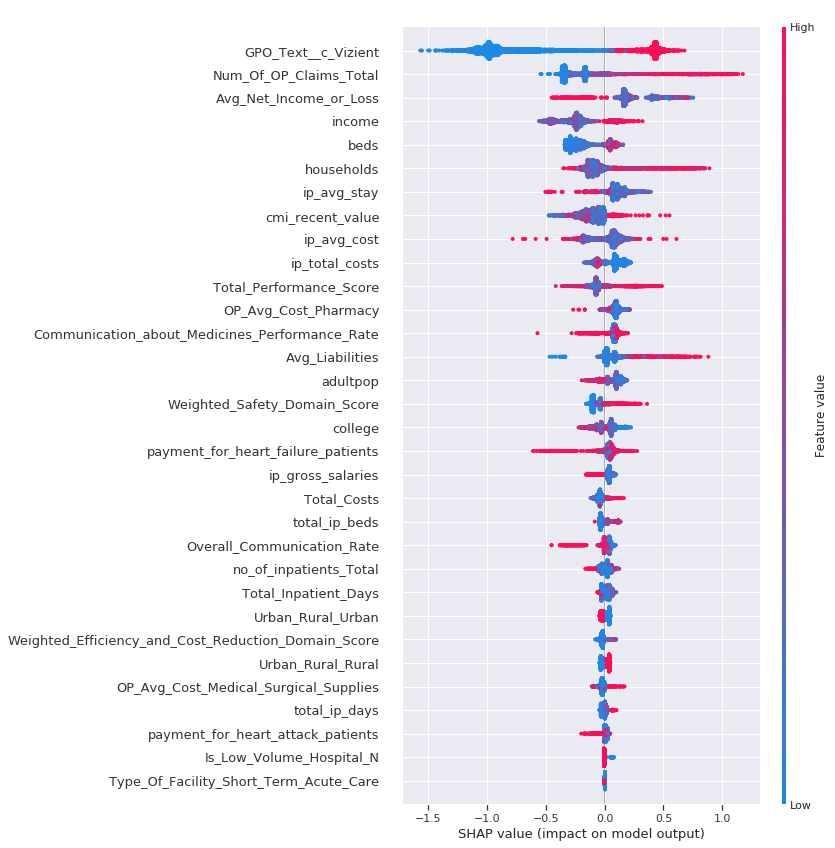

<Figure size 432x288 with 0 Axes>

In [839]:
shap.initjs()
tp_explainer = shap.TreeExplainer(tp_model)
tp_shap_values = tp_explainer.shap_values(third_party_lead_scoring_df_scaled_df[x_scaled_tp_cols_only])
shap.summary_plot(tp_shap_values, third_party_lead_scoring_df_scaled_df[x_scaled_tp_cols_only],max_display=len(x_scaled_tp_cols_only),show=False,title="TP Prediction Features")
plt.show()
plt.savefig('tp_shap_all_features.png',bbox_inches='tight', pad_inches=0)


In [840]:
tp_SHAP_features_importance_df = get_SHAP_features_importance(shap_values=tp_shap_values,all_features_names=x_scaled_tp_cols_only)
tp_SHAP_features_importance_df.head()
tp_shap_features_effect_df = get_SHAP_model_effect(tp_shap_values, third_party_lead_scoring_df_scaled_df)
tp_shap_features_effect_df.to_csv('new_accounts_rollup/new_accounts_rollup_tp_shap_features_importance.csv',index=False)
tp_shap_features_effect_df

,cust_account_std,feature,no.of_cust_accounts,no.of_cust_accounts_high_value(red),no.of_cust_accounts_low_value(blue),no.of_non_cust_accounts,no.of_non_cust_accounts_high_value(red),no.of_non_cust_accounts_low_value(blue),non_cust_account_std,overall_std,mean_shap_value,source
0,0.103777,GPO_Text__c_Vizient,1517.0,1503.0,14.0,3666.0,2.0,3664.0,0.229061,0.605325,0.726059,QuVa_SF
1,0.370386,Num_Of_OP_Claims_Total,835.0,835.0,0.0,4348.0,800.0,3548.0,0.099269,0.327518,0.299179,Third_Party_AHD
2,0.145553,Avg_Net_Income_or_Loss,4937.0,1092.0,3845.0,246.0,246.0,0.0,0.092976,0.175637,0.262432,Third_Party_AHD
3,0.046017,income,718.0,718.0,0.0,4465.0,999.0,3466.0,0.099496,0.160903,0.254874,Third_Party_Free_Data
4,0.027280,beds,1425.0,1425.0,0.0,3758.0,215.0,3543.0,0.065050,0.144636,0.188025,Third_Party_AHD
5,0.234765,households,959.0,899.0,60.0,4224.0,789.0,3435.0,0.047968,0.174307,0.127304,Third_Party_Free_Data
6,0.058874,ip_avg_stay,4940.0,1658.0,3282.0,243.0,235.0,8.0,0.102533,0.079433,0.119325,Third_Party_AHD
7,0.068856,cmi_recent_value,374.0,292.0,82.0,4809.0,2028.0,2781.0,0.084413,0.096083,0.115699,Third_Party_AHD
8,0.045423,ip_avg_cost,3646.0,1217.0,2429.0,1537.0,637.0,900.0,0.067044,0.122229,0.109466,Third_Party_AHD
9,0.047671,ip_total_costs,3457.0,3.0,3454.0,1726.0,1357.0,369.0,0.027940,0.093128,0.096089,Third_Party_AHD


In [841]:
tp_model.save_model('models/tp_model.model')
tp_shape_values_with_features_df = third_party_lead_scoring_df_scaled_df.copy()
tp_shape_values_with_features_df.columns = ["scaled_" + c for c in tp_shape_values_with_features_df.columns]
top_SHAP_features = list(get_SHAP_features_importance(tp_shap_values,x_scaled_tp_cols_only).feature.head(10))
top_SHAP_features = ["SHAP_"+c for c in top_SHAP_features]

tp_shap_values_df = pd.DataFrame(tp_shap_values,columns=["SHAP_"+c for c in x_scaled_tp_cols_only])
tp_shap_values_df = tp_shap_values_df[top_SHAP_features]                   
tp_shape_values_with_features_df = pd.concat([tp_shape_values_with_features_df,tp_shap_values_df],axis=1, sort=False)
tp_shape_values_with_features_df["Provider_ID"] = list(tp_provider_ids)
tp_shape_values_with_features_df["Provider_ID"] = tp_shape_values_with_features_df["Provider_ID"].astype(str)
tp_shape_values_with_features_df["Provider_ID"] = tp_shape_values_with_features_df["Provider_ID"].apply(lambda x : x.zfill(6))
tp_shape_values_with_features_df["Is_Customer"]= tp_model.predict(third_party_lead_scoring_df_scaled_df[x_scaled_tp_cols_only])
tp_shape_values_with_features_df.to_csv("../Hospitals_Features/tp_shape_values_df.csv",index=False)


In [842]:
len(tp_shape_values_with_features_df["Provider_ID"])

5183

In [843]:
third_party_df_2 = pd.merge(non_ahd_features_df,ahd_features_df,on="Provider_ID",how='right')
third_party_df_2 = third_party_df_2.append(definitive_third_party_df[third_party_df_2.columns])
third_party_df_2 = third_party_df_2.fillna(0)
third_party_df_2["ZIP_Code"] = third_party_df_2["ZIP_Code"].astype(int)
third_party_df_2["ZIP_Code"] = third_party_df_2["ZIP_Code"].astype(str)

third_party_lead_scoring_df_unscaled = pd.merge(third_party_df_2,provider_gpo_df,on='Provider_ID',how='left')
#third_party_lead_scoring_df_unscaled.columns = ["unscaled_" + c for c in third_party_lead_scoring_df.columns]
third_party_lead_scoring_df_unscaled["Provider_ID"] = third_party_lead_scoring_df_unscaled["Provider_ID"].astype(str)
third_party_lead_scoring_df_unscaled["Provider_ID"] = third_party_lead_scoring_df_unscaled["Provider_ID"].apply(lambda x : x.zfill(6))
third_party_lead_scoring_df_unscaled_joined = pd.merge(third_party_lead_scoring_df_unscaled,tp_shape_values_with_features_df,on="Provider_ID")
third_party_lead_scoring_df_unscaled_joined = third_party_lead_scoring_df_unscaled_joined.drop_duplicates()
third_party_lead_scoring_df_unscaled_joined = third_party_lead_scoring_df_unscaled_joined.drop(["Hospital_Name"],axis=1)

hospitals_gi_df["Provider_ID"] = hospitals_gi_df["Provider_ID"].astype(str)
hospitals_gi_df["Provider_ID"] = hospitals_gi_df["Provider_ID"].apply(lambda x : x.zfill(6))
third_party_lead_scoring_df_unscaled_joined = pd.merge(third_party_lead_scoring_df_unscaled_joined,hospitals_gi_df[["Provider_ID","Hospital_Name"]],on='Provider_ID')
#third_party_lead_scoring_df_unscaled = third_party_lead_scoring_df_unscaled[~third_party_lead_scoring_df_unscaled.Account_id.isna()]

print(len(third_party_lead_scoring_df_unscaled_joined))
len(third_party_lead_scoring_df_unscaled_joined.drop_duplicates())
third_party_lead_scoring_df_unscaled_joined.to_csv("new_accounts_rollup/new_accounts_rollup_QuVa_Third_Party_Lead_scores.csv",index=False)

5183


In [844]:
hospitals_gi_df[hospitals_gi_df.Provider_ID == "221302"]["Hospital_Name"].head()

2851    FAIRVIEW HOSPITAL
Name: Hospital_Name, dtype: object

In [845]:
#get opportunity - account 
sf_accounts_opps_df = pd.read_excel("../../data/QuVa-GAIL DataRequest_6_7_8_without_commas.xlsx","SF_OpportunityDetails")
sf_accounts_opp_df = sf_accounts_opps_df[["SF Account ID","SF Opportunity ID","Opportunity Status"]]
sf_accounts_opp_df.columns = ["SF_Account_ID","OpportunityId","Opportunity_Status"]
#get opportunity stages
opp_stages_df = pd.read_excel("../../data/QuVa-GAIL DataRequest_6_7_8_Addition2.xlsx","OpportunityStage")
replace_space_in_col_names(opp_stages_df)
opp_stages_df["CreatedDate"] = pd.to_datetime(opp_stages_df.CreatedDate).dt.to_period('D')
opp_stages_df = opp_stages_df.sort_values(by=["OpportunityId","CreatedDate","SystemModstamp"])
opp_stages_account_joined_df = pd.merge(sf_accounts_opp_df,opp_stages_df)
opp_stages_account_joined_df = opp_stages_account_joined_df[["SF_Account_ID","OpportunityId","StageName","CreatedDate","Opportunity_Status"]].drop_duplicates()

opp_stages_account_joined_df["Next_StageName"] = opp_stages_account_joined_df.groupby(['SF_Account_ID','OpportunityId'])['StageName'].shift(-1)
opp_stages_account_joined_df["Next_StageName"].fillna(opp_stages_account_joined_df["Opportunity_Status"],inplace=True)
opp_stages_account_joined_df = opp_stages_account_joined_df.drop(["Opportunity_Status"],axis=1)

In [718]:

opp_stages_account_grouped_df = opp_stages_account_joined_df.groupby(["SF_Account_ID","OpportunityId","StageName","Next_StageName"]).count().reset_index()
opp_stages_account_grouped_df = opp_stages_account_grouped_df[opp_stages_account_grouped_df.StageName != opp_stages_account_grouped_df.Next_StageName]
opp_stages_account_grouped_df = opp_stages_account_grouped_df.groupby(["SF_Account_ID","StageName","Next_StageName"]).count()
opp_stages_account_grouped_df = opp_stages_account_grouped_df.reset_index()
opp_stages_account_grouped_df["stage_transition"] = opp_stages_account_grouped_df["StageName"]+ "_to_" + opp_stages_account_grouped_df["Next_StageName"]
opp_stages_account_grouped_df = opp_stages_account_grouped_df.groupby(["SF_Account_ID","stage_transition"]).sum()["OpportunityId"].reset_index()
opp_stages_account_grouped_df = opp_stages_account_grouped_df.pivot(index="SF_Account_ID",columns="stage_transition",values="OpportunityId").fillna(0)
len(opp_stages_account_grouped_df.columns)

135

In [ ]:
list(sf_account_third_party_df.columns)

In [ ]:
len(sf_account_third_party_df)

In [ ]:
len(tp_shape_values_with_features_df)